In [1]:
import pygmt
import pandas as pd
import xarray as xr
from scipy.spatial import cKDTree
import rioxarray
from antarctic_plots import utils, regions, maps, fetch
import zarr
import verde as vd

c:\Users\matthewt\AppData\Local\miniforge3\envs\grav_inv_ant_plots\lib\site-packages\xarray\backends\cfgrib_.py:29: UserWarning: Failed to load cfgrib - most likely there is a problem accessing the ecCodes library. Try `import cfgrib` to get the full error message
  warnings.warn(


# Set grid parameters

In [2]:
bedmachine_bed = xr.open_zarr("../inversion_layers/bedmachine_bed.zarr")['bed']

spacing, region, vmax, vmin, registration = utils.get_grid_info(bedmachine_bed)

print("spacing:", spacing)
print("region:", region)
print("registration:", registration)

c:\Users\matthewt\AppData\Local\miniforge3\envs\grav_inv_ant_plots\lib\site-packages\xarray\backends\plugins.py:71: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


spacing: 1000.0
region: [-1560000.0, 1400000.0, -2400000.0, 560000.0]
registration: g


# Load constraint points

In [3]:
constraints = pd.read_csv(
    "../bedmachine_RIGGS.csv.gz",
    sep=',',
    header='infer',
    index_col=None,
    compression="gzip",
)
constraints

,x,y,bed
0,-1.560000e+06,-2.400000e+06,-4972.899902
1,-1.559000e+06,-2.400000e+06,-4925.698242
2,-1.558000e+06,-2.400000e+06,-4870.687500
3,-1.557000e+06,-2.400000e+06,-4808.214355
4,-1.556000e+06,-2.400000e+06,-4736.370605
...,...,...,...
8287284,-2.180501e+05,-8.164639e+05,-564.000000
8287285,-4.524669e+05,-1.087485e+06,-714.000000
8287286,-2.144458e+05,-1.033177e+06,-512.000000
8287287,-1.971893e+05,-8.266453e+05,-583.000000


# Calculate distance to nearest constraint at all points on a regular grid

In [4]:
df_grid = vd.grid_to_table(bedmachine_bed)[['x', 'y']]
df_grid

,x,y
0,-1560000.0,-2400000.0
1,-1559000.0,-2400000.0
2,-1558000.0,-2400000.0
3,-1557000.0,-2400000.0
4,-1556000.0,-2400000.0
...,...,...
8767516,1396000.0,560000.0
8767517,1397000.0,560000.0
8767518,1398000.0,560000.0
8767519,1399000.0,560000.0


In [5]:
df_points = constraints[['x','y']]
df_points

,x,y
0,-1.560000e+06,-2.400000e+06
1,-1.559000e+06,-2.400000e+06
2,-1.558000e+06,-2.400000e+06
3,-1.557000e+06,-2.400000e+06
4,-1.556000e+06,-2.400000e+06
...,...,...
8287284,-2.180501e+05,-8.164639e+05
8287285,-4.524669e+05,-1.087485e+06
8287286,-2.144458e+05,-1.033177e+06
8287287,-1.971893e+05,-8.266453e+05


In [6]:
min_dists, min_dist_idx = cKDTree(df_points.values).query(df_grid.values,1)

In [7]:
df_grid['min_dist']=min_dists
df_grid.describe()

,x,y,min_dist
count,8.767521e+06,8.767521e+06,8.767521e+06
mean,-8.000000e+04,-9.200000e+05,9.596950e+02
std,8.547671e+05,8.547671e+05,4.584603e+03
min,-1.560000e+06,-2.400000e+06,0.000000e+00
25%,-8.200000e+05,-1.660000e+06,0.000000e+00
50%,-8.000000e+04,-9.200000e+05,0.000000e+00
75%,6.600000e+05,-1.800000e+05,0.000000e+00
max,1.400000e+06,5.600000e+05,6.231003e+04


In [8]:
dist_grid = pygmt.xyz2grd(
    df_grid, 
    region=regions.ross_ice_shelf, # zoom in to reduce comp times
    spacing=spacing,
    registration=registration,
    )
utils.get_grid_info(dist_grid)

(1000.0, [-680000.0, 470000.0, -1420000.0, -310000.0], 0.0, 62310.0273438, 'g')

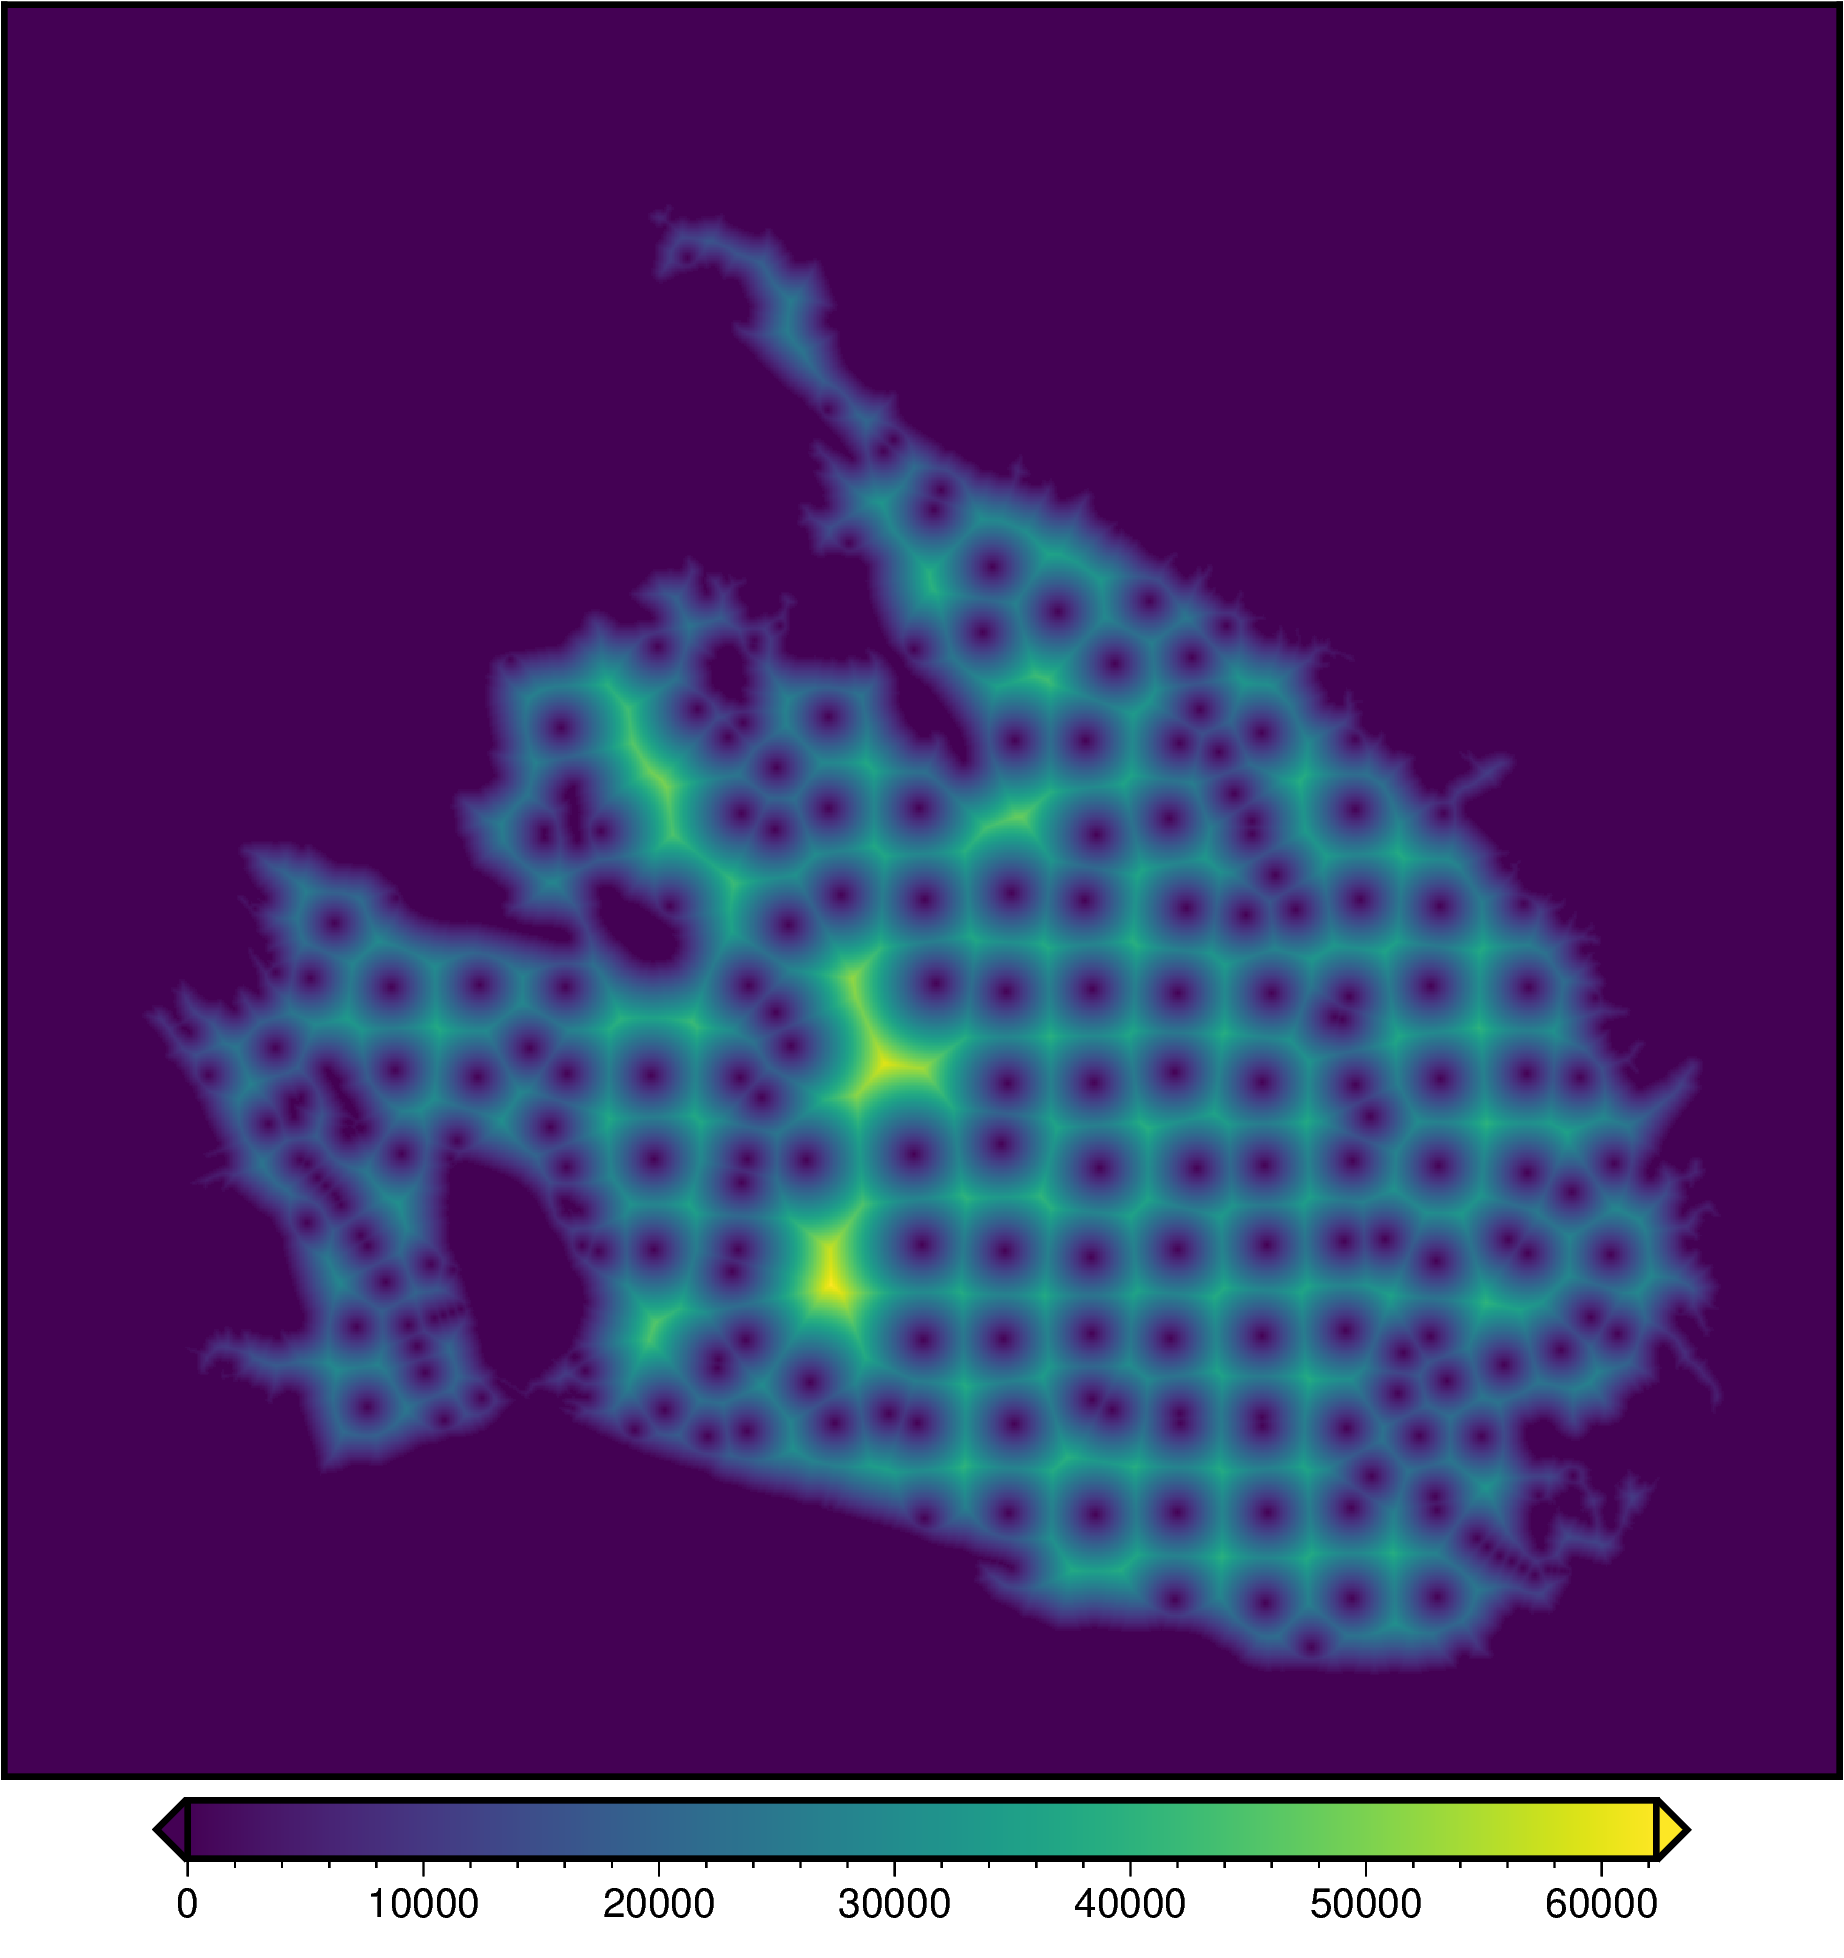

In [9]:
fig = maps.plot_grd(dist_grid)
fig.show()

# Convert distance grid to constraint grid

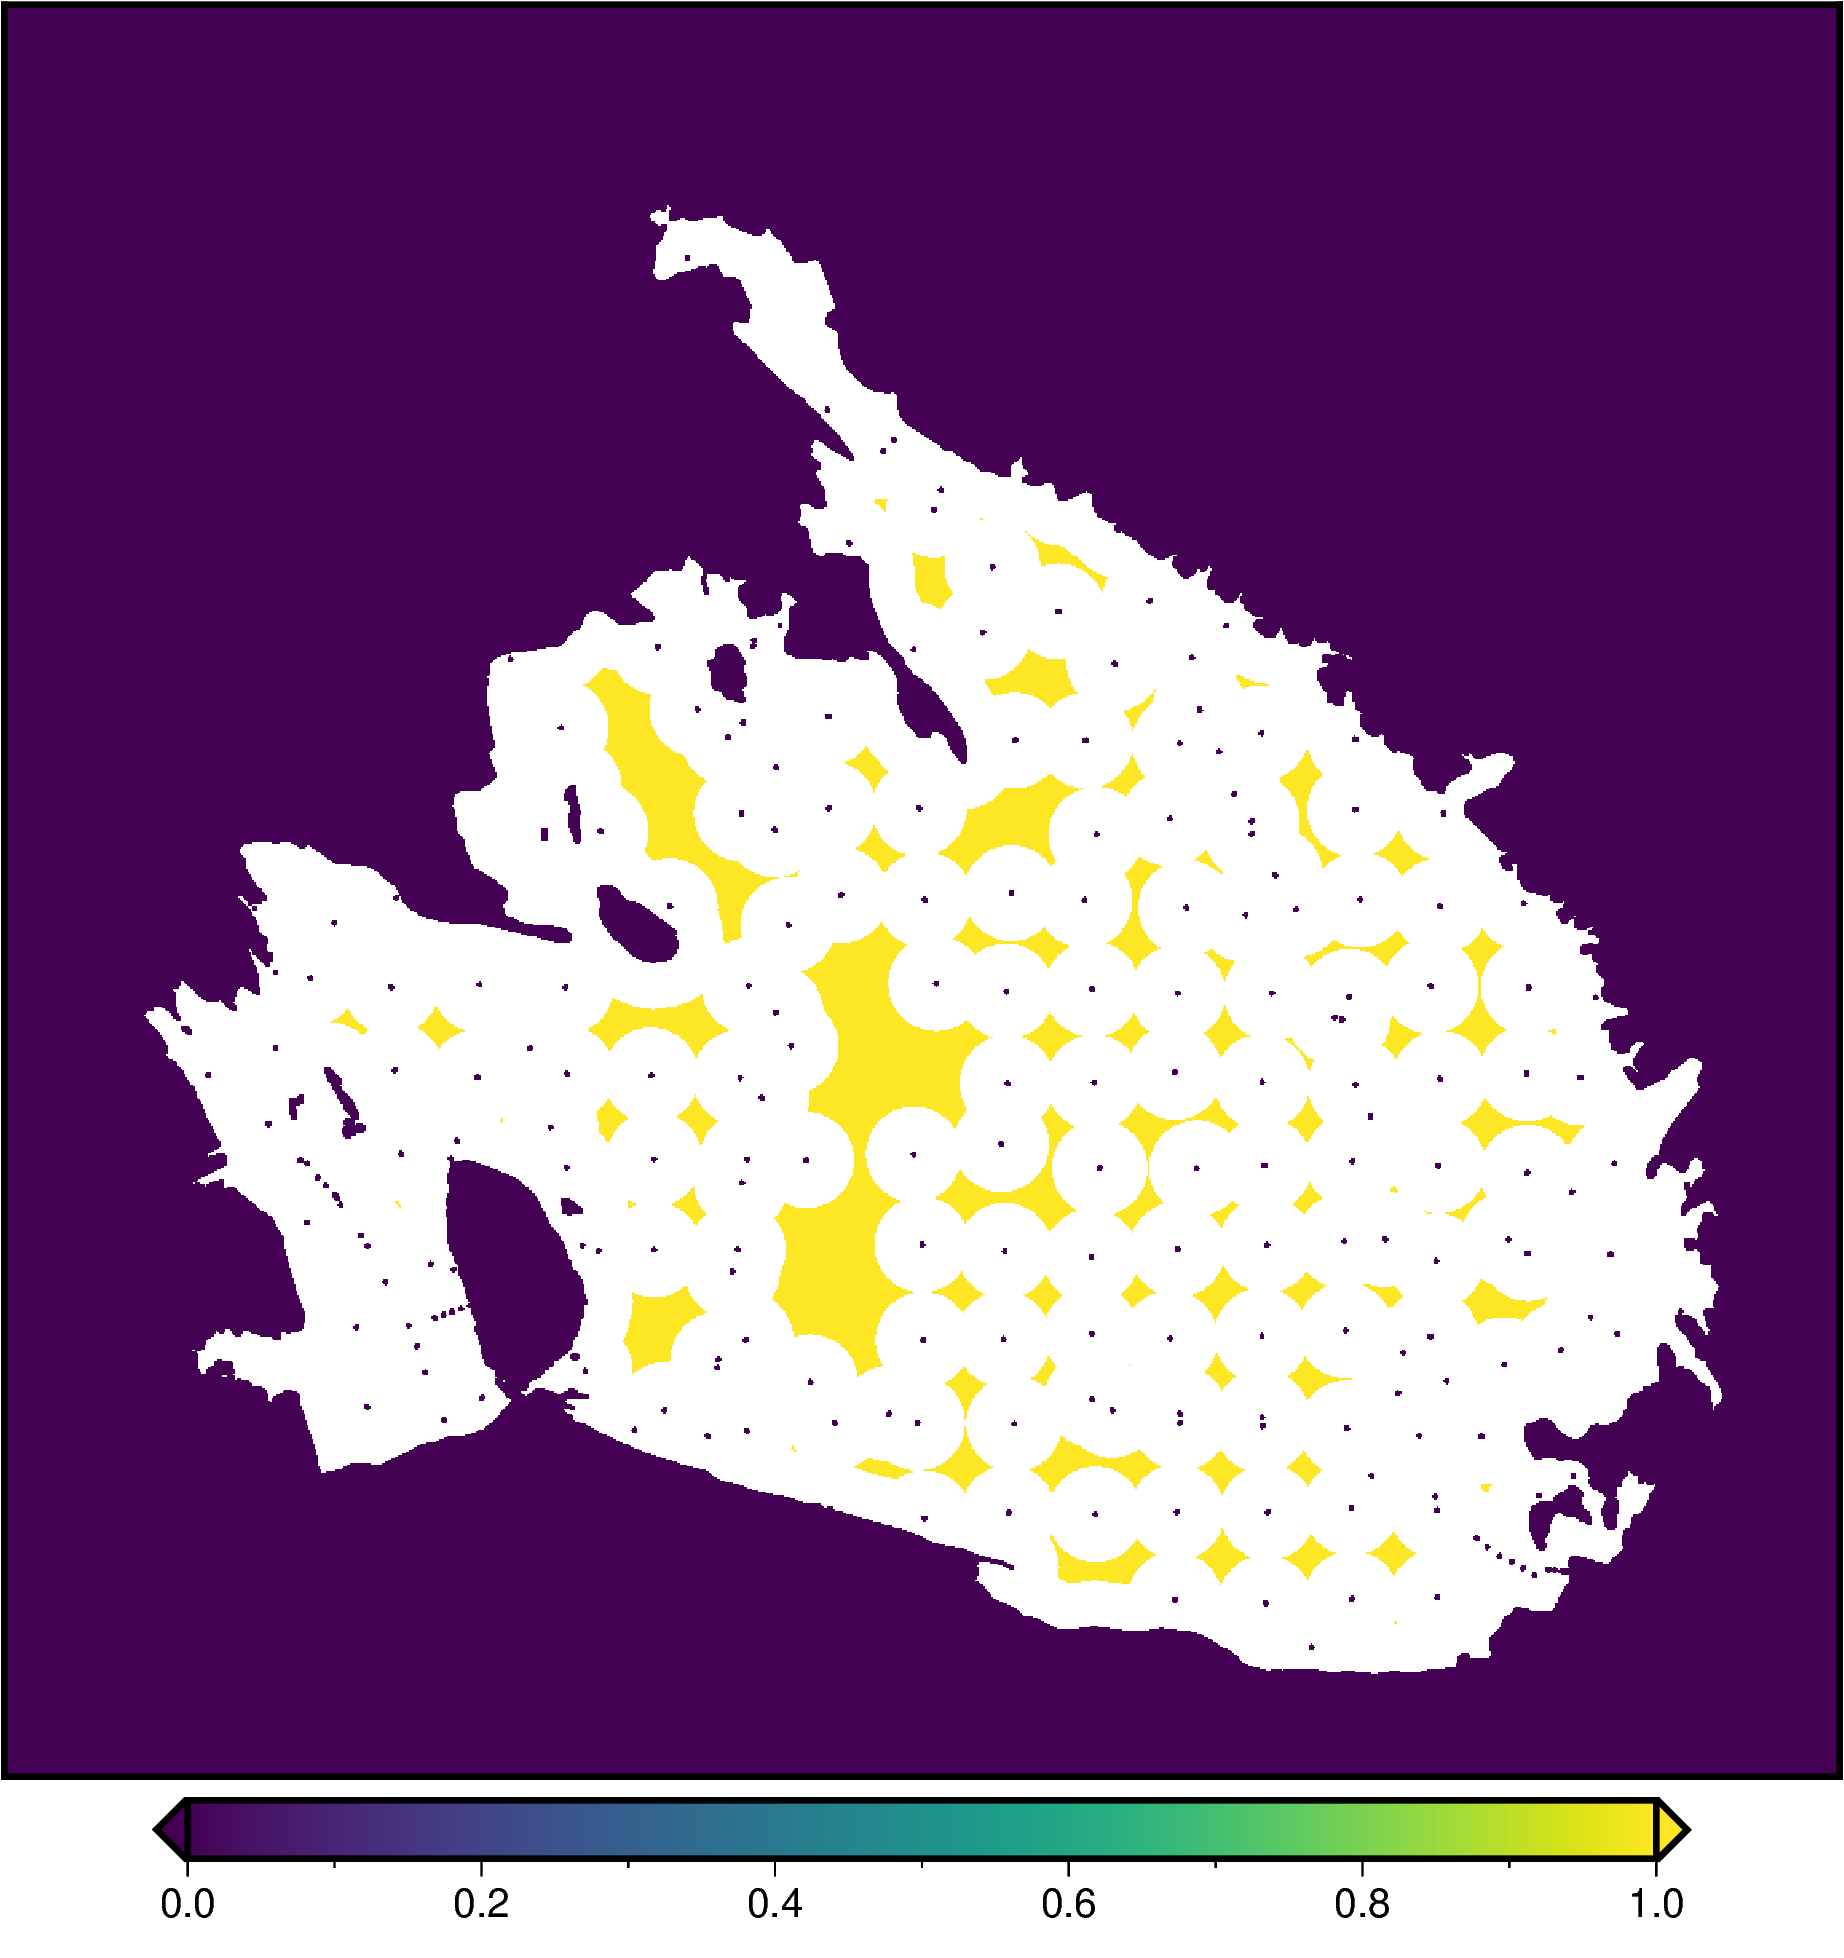

In [10]:
outer = 30e3
inner = 2e3
# if distance to nearest constraint > outer, set to 1 (fully free to invert)
# if distance to nearest constraint < inner, set to 0 (completely constrained)
# if distance to nearest constraint between inner and out, set to NaN 
dist_clip = pygmt.grdclip(
    dist_grid, 
    above=[outer,1],
    below=[inner,0],
    between=[inner, outer, 'NaN']
    )
    
fig = maps.plot_grd(dist_clip)
fig.show()

In [13]:
# if distance between inner and outer, linearly increase from 0 to 1
dist_clip=dist_clip.rio.write_crs("epsg:3031")
grid = dist_clip.rio.interpolate_na(method='linear')
grid

<xarray.DataArray 'z' (y: 1111, x: 1151)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])
Coordinates:
  * x            (x) float64 -6.8e+05 -6.79e+05 -6.78e+05 ... 4.69e+05 4.7e+05
  * y            (y) float64 -1.42e+06 -1.419e+06 ... -3.11e+05 -3.1e+05
    spatial_ref  int32 0
Attributes:
    long_name:     z
    actual_range:  [0. 1.]

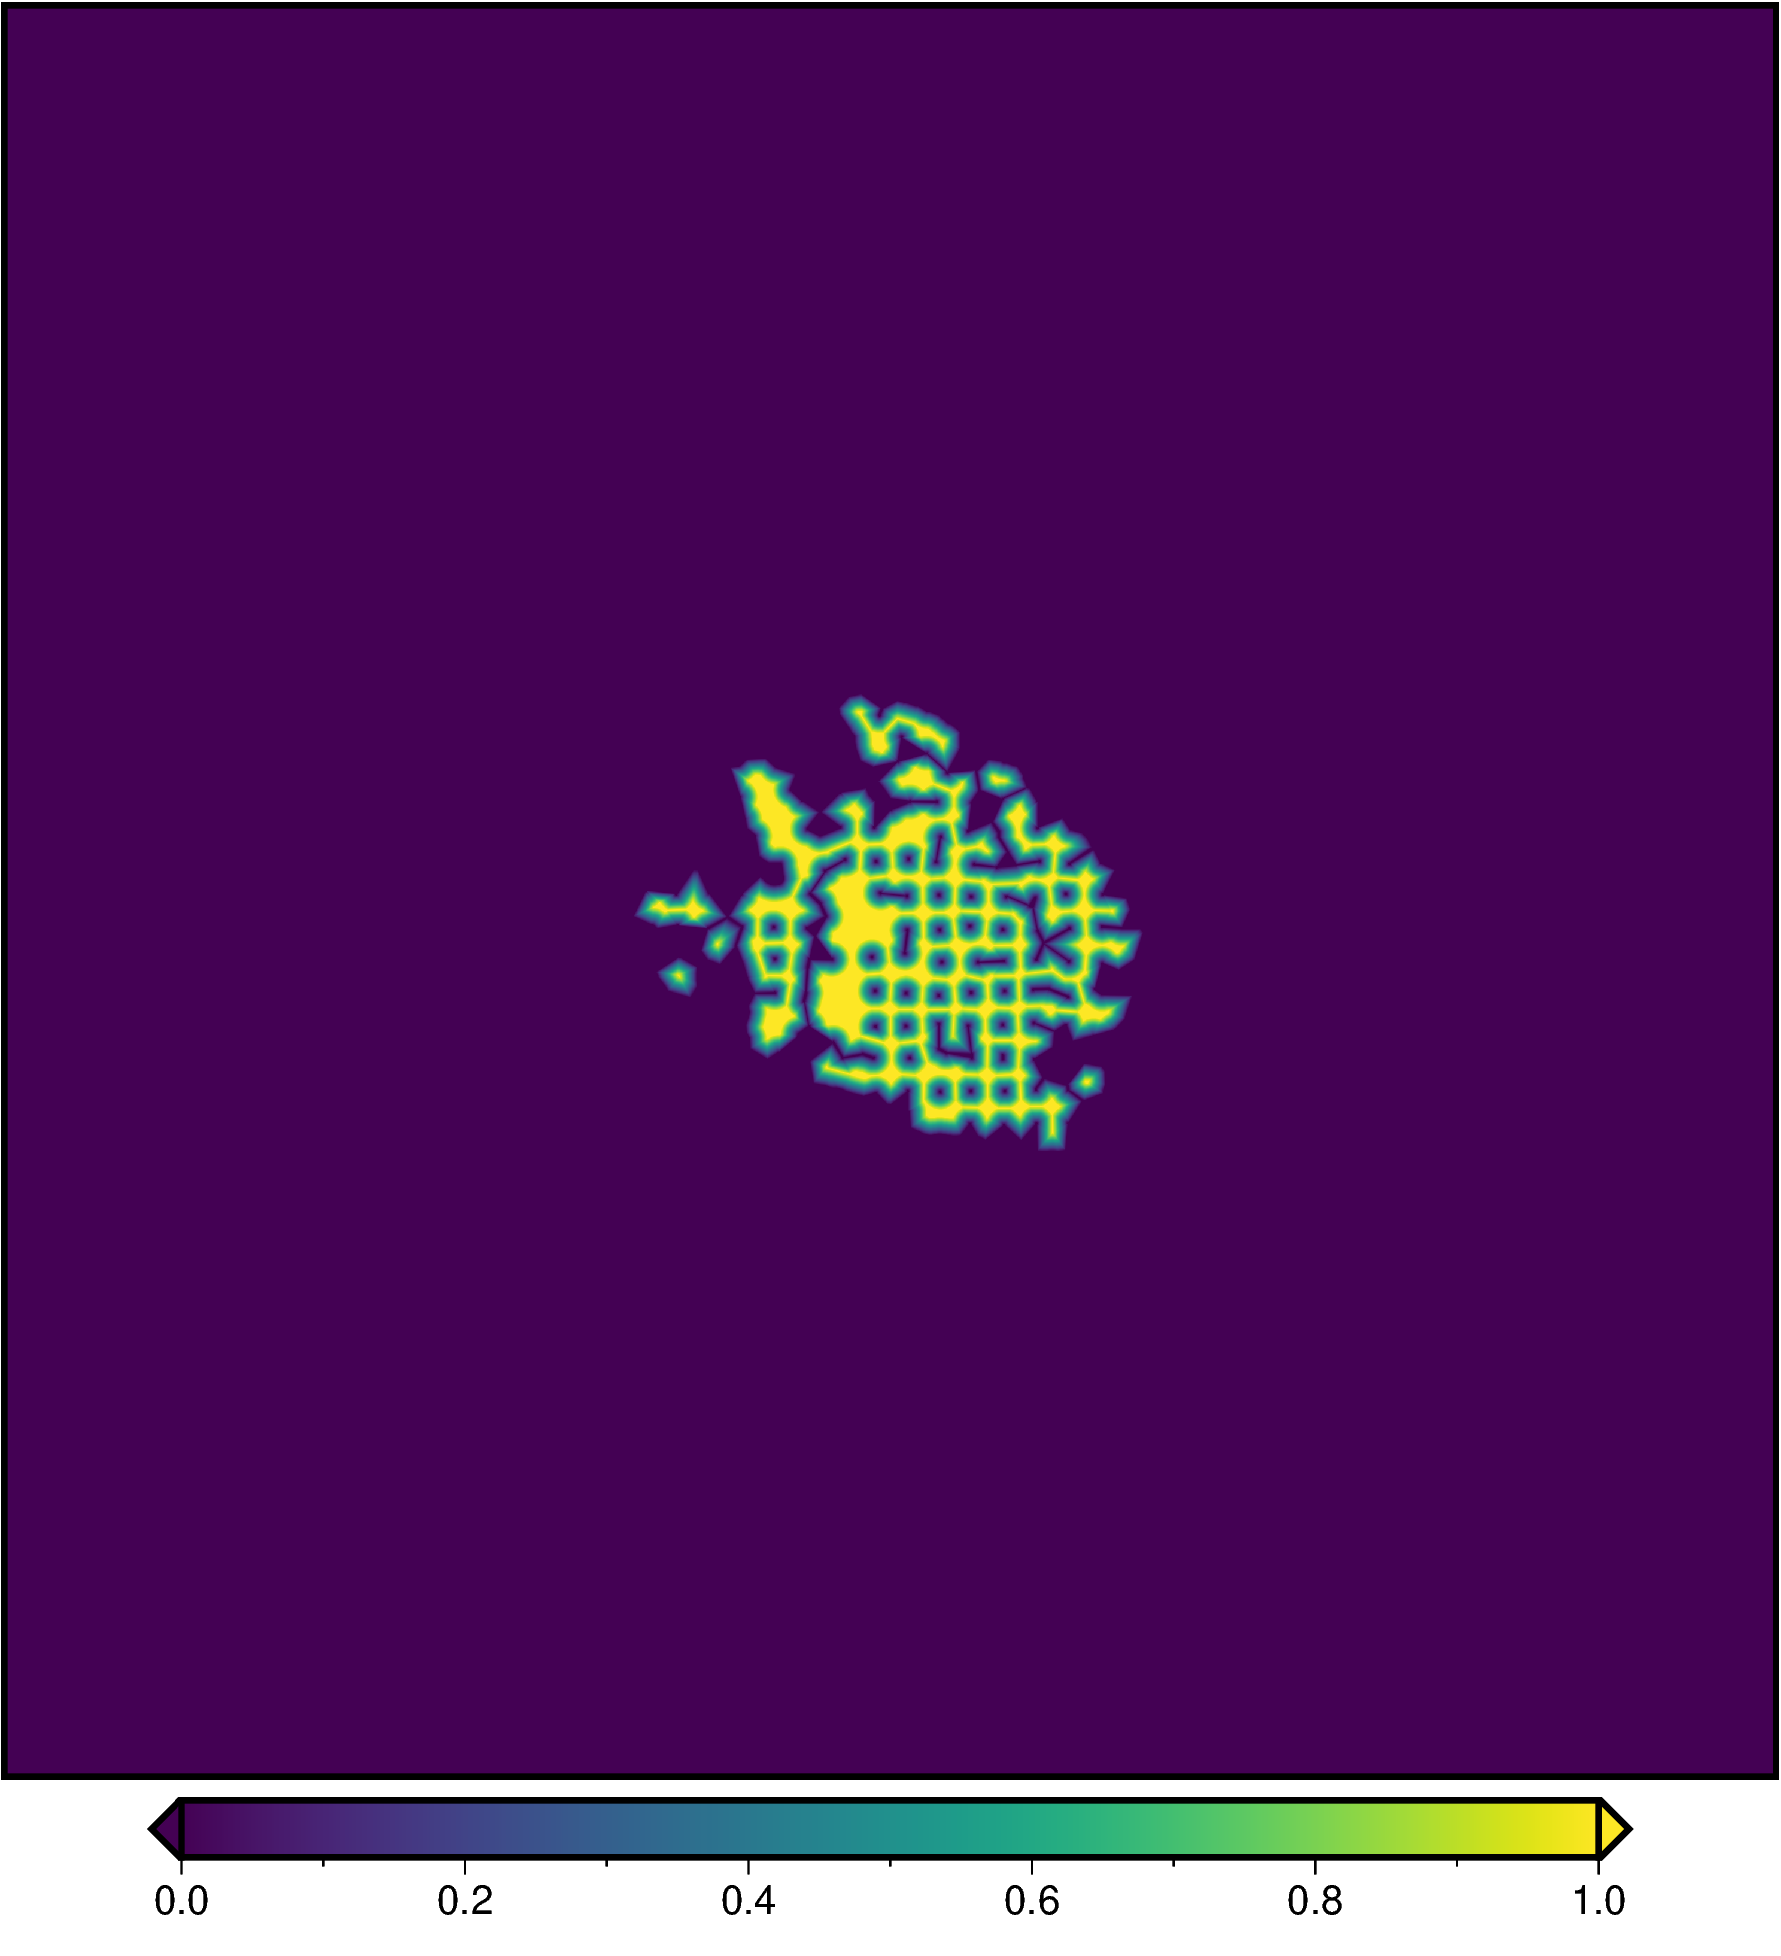

In [18]:
# extend back to original region
constraints_grid = grid.interp_like(
    bedmachine_bed, 
    kwargs={'fill_value':0}
    )

fig = maps.plot_grd(constraints_grid)

fig.show()

In [28]:
assert utils.get_grid_info(constraints_grid)[0] == utils.get_grid_info(bedmachine_bed)[0]
assert utils.get_grid_info(constraints_grid)[1] == utils.get_grid_info(bedmachine_bed)[1]
assert utils.get_grid_info(constraints_grid)[4] == utils.get_grid_info(bedmachine_bed)[4]

# Save to .zarr file

In [29]:
constraints_grid = constraints_grid.to_dataset(name='z')

constraints_grid.to_zarr(
    "../constraints_grid.zarr", 
    encoding={"z": {"compressor": zarr.Blosc()}},
    mode="w",
    )

# Load and plot .zarr

In [30]:
constraints_grid = xr.open_zarr("../constraints_grid.zarr")['z']
constraints_grid

<xarray.DataArray 'z' (y: 2961, x: 2961)>
dask.array<open_dataset-8825d7d9ea90849007a964bf1e53d283z, shape=(2961, 2961), dtype=float64, chunksize=(371, 371), chunktype=numpy.ndarray>
Coordinates:
    spatial_ref  int32 ...
  * x            (x) float64 -1.56e+06 -1.559e+06 ... 1.399e+06 1.4e+06
  * y            (y) float64 -2.4e+06 -2.399e+06 -2.398e+06 ... 5.59e+05 5.6e+05
Attributes:
    actual_range:  [0.0, 1.0]
    long_name:     z

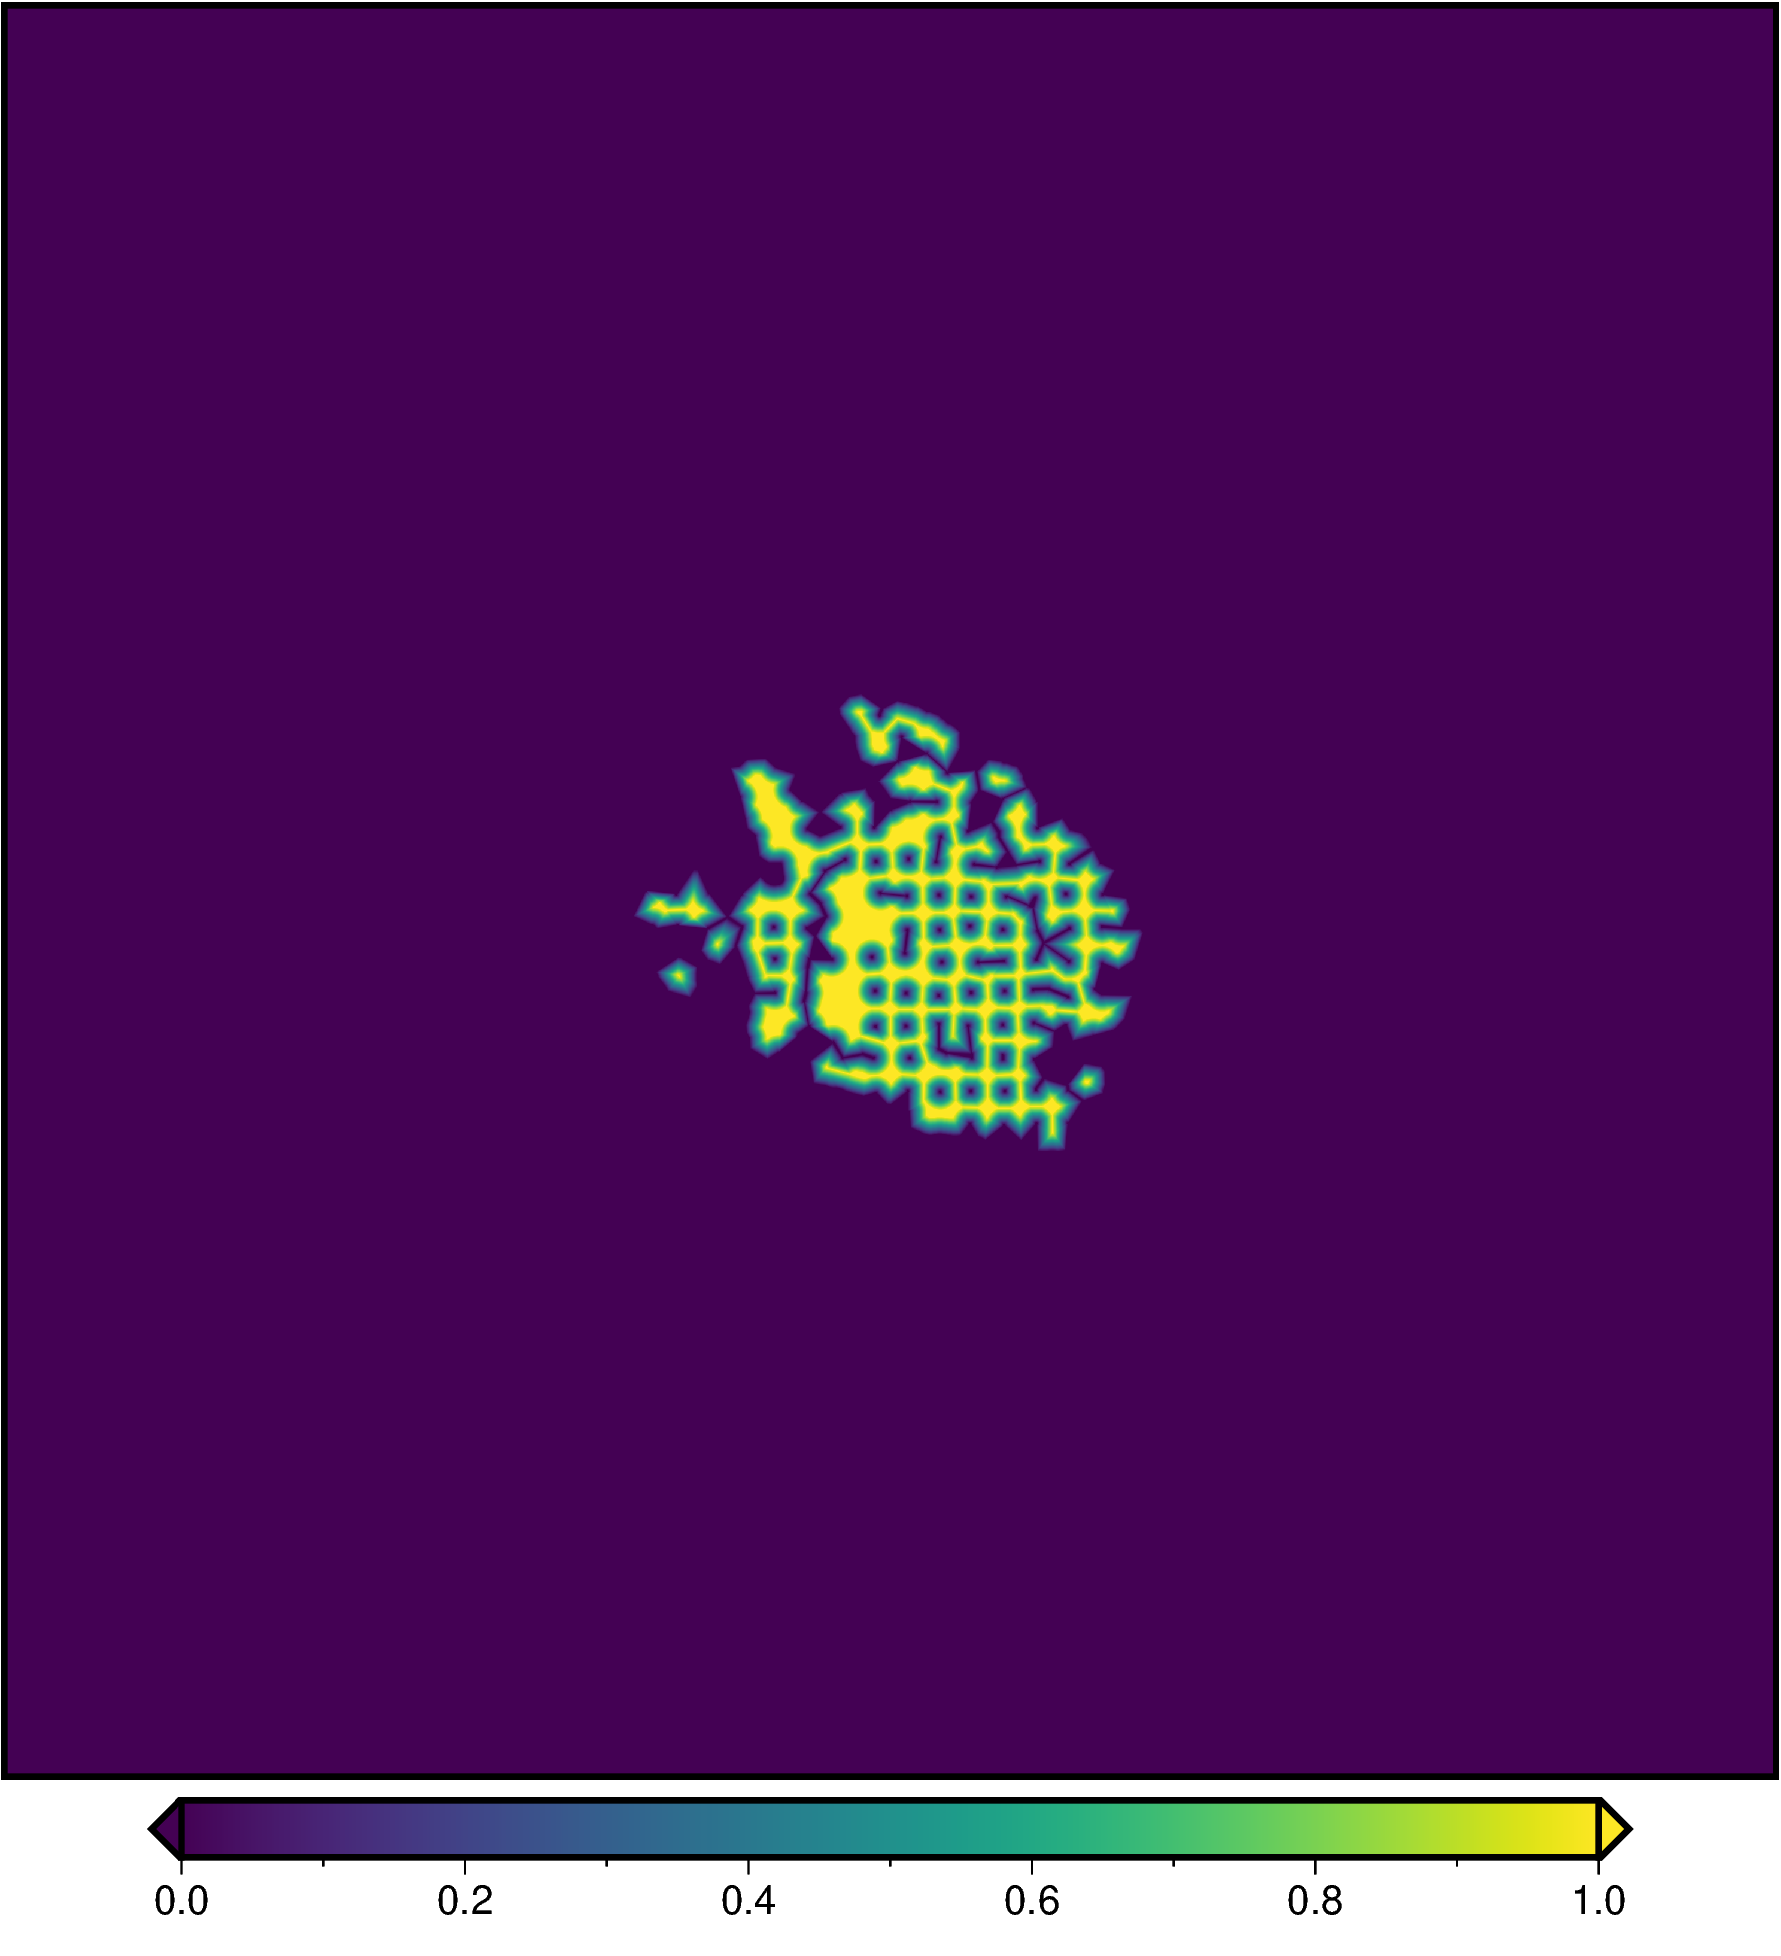

In [31]:
fig = maps.plot_grd(constraints_grid)
fig.show()